In [1]:
# !pip install -q -U "tensorflow-text==2.8.*"

In [2]:
# !pip install -q tf-models-official==2.7.0

In [3]:
# !pip install -q pydot

In [4]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
# train_df = pd.read_csv('../data/processed/train_data_processed.csv', index_col='id')
# test_df = pd.read_csv('../data/processed/train_data_processed.csv', index_col='id')
train_df = pd.read_csv('../data/processed/fewer_labels/7_genres_train_data_processed.csv', index_col='id')
test_df = pd.read_csv('../data/processed/fewer_labels/7_genres_test_data_processed.csv', index_col='id')

In [7]:
# def truncate_and_split_descriptions(df, batch_size=128):
#     new_df_dict = {'genre':[], 'processed_description_string': []}
#     for _, row in df.iterrows():
#         processed_description = row['processed_description_string'].split()
#         genre = row['genre']
#         n = len(processed_description)
#         for i in range(0, n, batch_size):
#             new_df_dict['genre'].append(genre)
#             new_df_dict['processed_description_string'].append(' '.join(processed_description[i:min(n, i+batch_size)]))
#     new_df = pd.DataFrame(new_df_dict)
#     return new_df

In [8]:
# train_df = truncate_and_split_descriptions(train_df)

In [9]:
unique_genres = train_df['genre'].unique()
genre_encoding = dict([(unique_genres[i], i) for i in range(unique_genres.shape[0])])
train_df['genre'] = train_df['genre'].map(genre_encoding)
test_df['genre'] = test_df['genre'].map(genre_encoding)

In [10]:
train_df

,title,genre,description,year,language,processed_description_string
id,,,,,,
1,Oscar et la dame rose,0,Listening in to a conversation between his do...,2009,English,listen convers doctor parent 10-year-old oscar...
2,Cupid,1,A brother and sister with a past incestuous r...,1997,English,brother sister past incestu relationship curre...
4,The Secret Sin,0,To help their unemployed father make ends mee...,1915,English,help unemploy father make end meet edith twin ...
5,The Unrecovered,0,The film's title refers not only to the un-re...,2007,English,film titl refer un-recov bodi ground zero also...
6,Quality Control,2,Quality Control consists of a series of 16mm ...,2011,English,qualiti control consist seri 16mm singl take s...
...,...,...,...,...,...,...
54209,Izpiti po nikoe vreme,8,"First story, ""Temptation"": Two kids find a wa...",1974,English,first stori temptat : two kid find wallet happ...
54210,"""Bonino""",3,This short-lived NBC live sitcom centered on ...,1953,English,short-liv nbc live sitcom center bonino world-...
54211,Dead Girls Don't Cry,5,The NEXT Generation of EXPLOITATION. The sist...,????,English,next gener exploit sister kapa - bay soror hou...


In [11]:
test_df

,title,genre,description,year,language,processed_description_string
id,,,,,,
1,Edgar's Lunch,1,"L.R. Brane loves his life - his car, his apar...",1998,English,lr brane love life - car apart job especi girl...
2,La guerra de papá,3,"Spain, March 1964: Quico is a very naughty ch...",1977,English,spain march 1964 : quico naughti child three b...
3,Off the Beaten Track,2,One year in the life of Albin and his family ...,2010,English,one year life albin famili shepherd north tran...
4,Meu Amigo Hindu,0,"His father has died, he hasn't spoken with hi...",2015,English,father die hasnt spoken brother 10 year seriou...
5,Er nu zhai,0,Before he was known internationally as a mart...,1955,English,known intern martial art superstar bruce lee a...
...,...,...,...,...,...,...
54194,The World of Art Presents: Drawing for Anyone...,8,Jump right in to drawing animals along with C...,2009,English,jump right draw anim along chuck mclachlan des...
54196,"""Tales of Light & Dark""",5,"Covering multiple genres, Tales of Light & Da...",2013,English,cover multipl genr tale light dark antholog we...
54197,Der letzte Mohikaner,7,As Alice and Cora Munro attempt to find their...,1965,English,alic cora munro attempt find father british of...


In [12]:
num_labels = train_df['genre'].nunique()
num_labels

9

In [13]:
x_train = train_df['processed_description_string'].values
y_train = pd.get_dummies(train_df['genre']).values

In [14]:
x_test = test_df['processed_description_string'].values
y_test = pd.get_dummies(test_df['genre']).values

In [15]:
num_examples = train_df.shape[0]

train_set_size = int(num_examples * 0.95)
val_set_size = num_examples - train_set_size

x_val = x_train[train_set_size:]
x_train = x_train[:train_set_size]

y_val = y_train[train_set_size:]
y_train = y_train[:train_set_size]

In [16]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-2_H-128_A-2'

map_name_to_handle = {
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
}

map_model_to_preprocess = {
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [17]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

2022-11-30 01:21:51.537795: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [18]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [19]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    # net = tf.keras.layers.Dense(128)(net)
    # net = tf.keras.layers.Dropout(0.1)(net)
    # net = tf.keras.layers.Dense(512)(net)
    # net = tf.keras.layers.Dense(256)(net)
    net = tf.keras.layers.Dense(num_labels, activation='softmax')(net)
    return tf.keras.Model(text_input, net)

In [20]:
classifier_model = build_classifier_model()

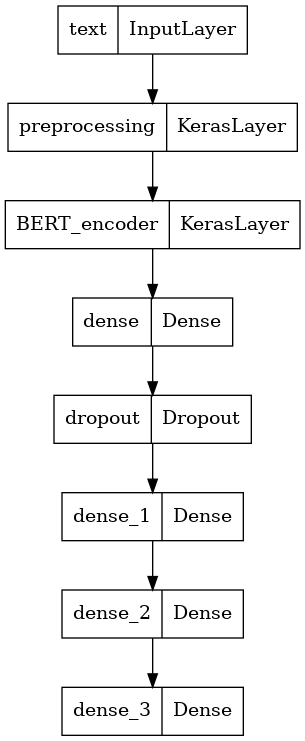

In [21]:
tf.keras.utils.plot_model(classifier_model, to_file='../models/{}.png'.format(bert_model_name))

In [22]:
epochs = 10

In [23]:
classifier_model.compile(optimizer='adam',
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])

In [24]:
print(f'Training model with {tfhub_handle_encoder}')

my_callbacks  = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=0,
                              mode='auto')]
history = classifier_model.fit(x_train, y_train,
                    epochs=epochs,
                    validation_data=(x_val, y_val),
                    callbacks=my_callbacks,
                    verbose=1
                   )

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Epoch 1/10
1237/1237 [==============================] - 43s 33ms/step - loss: 1.1347 - accuracy: 0.6159 - val_loss: 0.9575 - val_accuracy: 0.6774
Epoch 2/10
1237/1237 [==============================] - 41s 33ms/step - loss: 0.8222 - accuracy: 0.7264 - val_loss: 0.9376 - val_accuracy: 0.6899


In [25]:
loss, accuracy = classifier_model.evaluate(x_test, y_test)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

1301/1301 [==============================] - 32s 25ms/step - loss: 0.9424 - accuracy: 0.6887
Loss: 0.9424145221710205
Accuracy: 0.6887009739875793


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


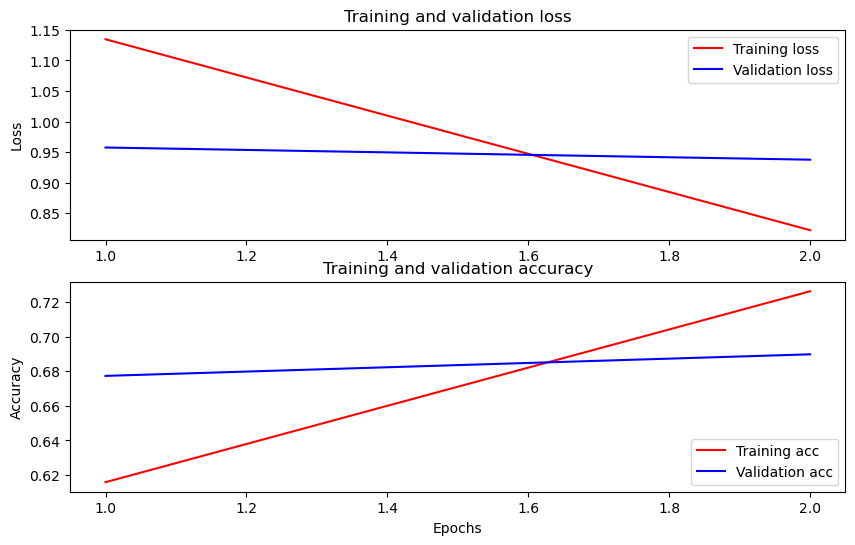

In [26]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [27]:
saved_model_path = '../models/{}'.format(bert_model_name)

classifier_model.save(saved_model_path, include_optimizer=False)

In [28]:
s = "An elite group of mercenaries named The Expendables, who are based in New Orleans deploys to the Gulf of Aden to save hostages on a vessel from Somali pirates. The team consists of leader Barney Ross, blade specialist Lee Christmas, martial artist Yin Yang, military veteran Gunner Jensen, weapons specialist Hale Caesar, and demolitions expert Toll Road. Jensen instigates a firefight, causing casualties for the pirates. He then tries to hang a pirate, but Yang stops him when Ross and the team discourage the idea. Ross reluctantly discharges him from the team. Later, Christmas is upset to discover his girlfriend Lacy has left him for another man. Ross and rival Trench Mauser visit 'Mr.Church' for a mission. Trench passes the contract to Ross, which is to overthrow dictator General Garza in Vilena, an island in the Gulf of Mexico. Ross and Christmas fly to Vilena for undercover reconnaissance and meet their contact, Sandra, but are discovered. It is revealed that ex-CIA officer James Munroe is keeping Garza in power as a figurehead for his own profiteering operations, while Sandra is revealed to be Garza's daughter. Ross aborts, but Sandra refuses to leave Vilena. Meanwhile, Jensen approaches Munroe to help and Garza is angered further when Sandra is waterboarded for information by Munroe. Meanwhile, Lacy has been physically abused by her new man, so Christmas beats him and his friends, revealing what he does for a living. Ross and the group discover that Church is a CIA operative and the real target is Munroe, who has gone rogue and joined forces with Garza to keep the drug money that funds the CIA to himself, but the CIA cannot afford a mission to kill one of their own directly because of bad publicity. Ross meets tattoo expert and friend Tool to express his feelings. Tool makes a confession about letting a woman commit suicide instead of saving her. Ross is then motivated to go back for Sandra alone, but Yang accompanies him. Jensen and hired men pursue them on the road, ending in an abandoned warehouse, where Yang and Jensen fight a second time. Ross shoots Jensen when he attempts to impale Yang on a pipe. Jensen makes amends and gives the layout of Garza's palace. Ross boards the plane with Yang and finds the rest of the team waiting, and they infiltrate Garza's compound. Thinking Munroe hired the team to kill him, Garza has his soldiers' faces painted, preparing them for a fight. The team plants explosives throughout the site but Ross, while saving Sandra, is captured by Munroe's henchmen. The team saves him and kills the Brit, but is pinned down by Garza's men as Paine wrestles Ross. Caesar fights back and Paine escapes. Garza finally stands up to Munroe, ordering him out and returning his money. Instead, as Garza rallies his men against the Americans, Munroe kills him and escapes with Paine and Sandra. Garza's men open fire against the team, who fight their way through, detonating the explosives and destroying the compound. Toll kills Paine by burning him alive while Ross and Caesar manage to destroy the helicopter before Munroe can escape. Ross and Christmas catch up to Munroe, killing him and saving Sandra. Later, Ross gives his mission reward to Sandra to restore Vilena. The team has returned home and are celebrating at Tool's tattoo parlor with the recovering and now redeemed Jensen. Christmas and Tool play a game of knife throwing, during which Christmas composes a mocking poem about Tool, then throws a bullseye from outside the building."
x_custom = np.array([s.lower()])

In [29]:
classifier_model.predict(x_custom)[0]

array([0.01309674, 0.0074584 , 0.76652247, 0.03332235, 0.06077089,
       0.00337916, 0.07832316, 0.03121814, 0.00590868], dtype=float32)

In [30]:
genre_encoding

{'drama': 0,
 'thriller': 1,
 'documentary': 2,
 'comedy': 3,
 'reality-tv': 4,
 'horror': 5,
 'action': 6,
 'western': 7,
 'family': 8}

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score


def get_confusion_matrix(y_true, y_pred):
    fig, ax = plt.subplots(figsize=(15, 15))
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, ax=ax)
    plt.show()

    return None


def get_f1_score(y_true, y_pred):
    f1 = f1_score(y_true, y_pred, average='weighted')
    return f1

In [32]:
y_pred = classifier_model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

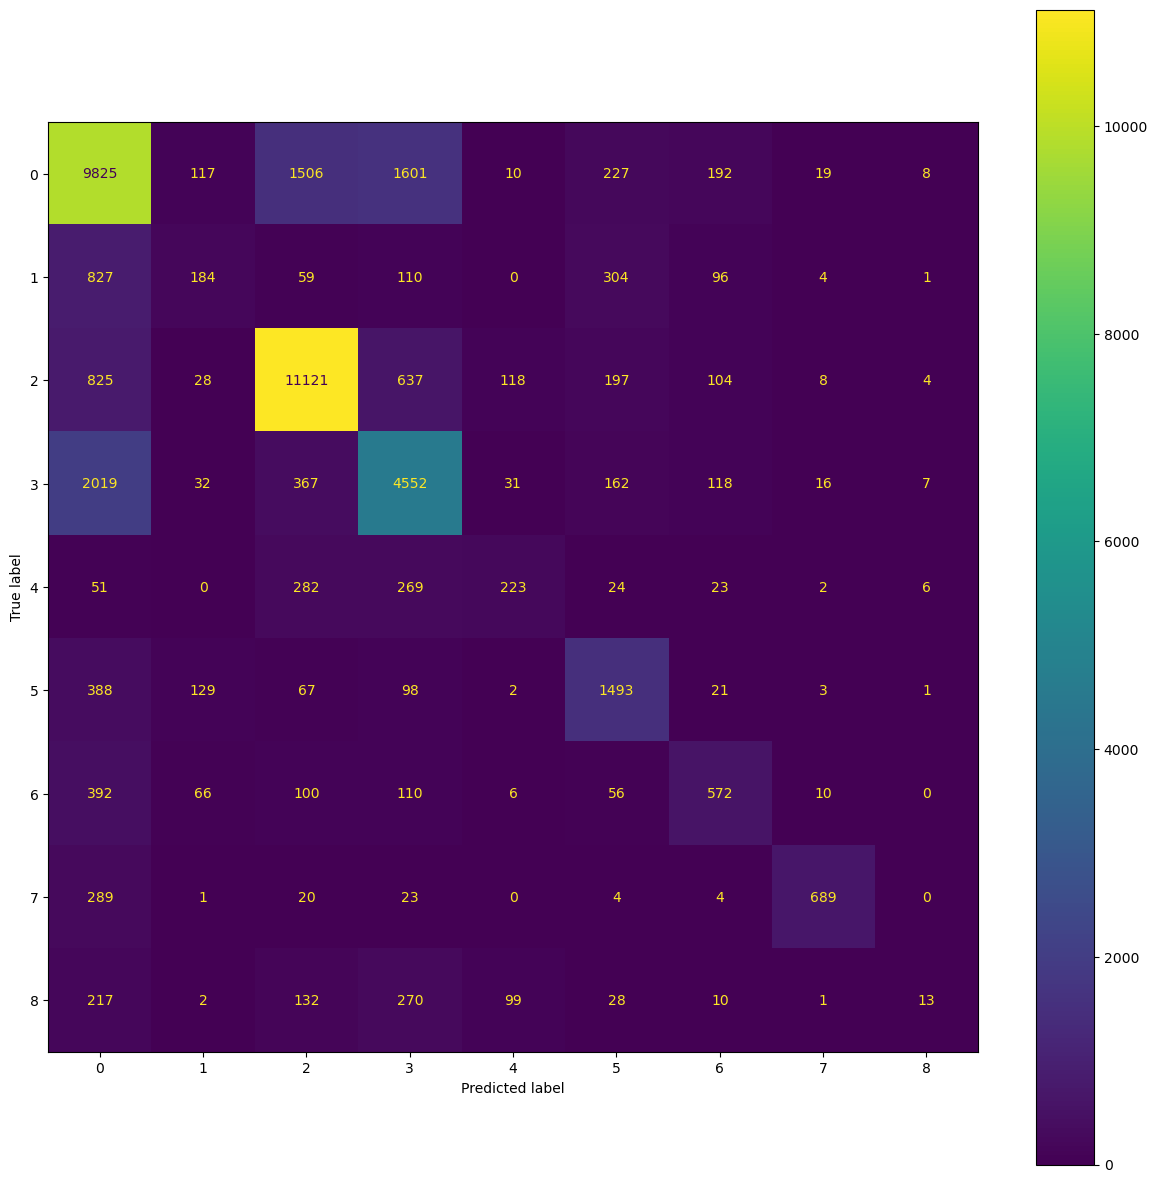

In [33]:
get_confusion_matrix(np.argmax(y_test, axis=1), y_pred)

In [34]:
get_f1_score(np.argmax(y_test, axis=1), y_pred)

0.6740801302014748